# BIG DATA ANALYTICS PROJECT
**Student Name:** [Zeynep Dagtekin]
**Student ID:** [2121251007]

---
## PART 1: MapReduce Implementation
In this section i implement MapReduce to my dataset

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MapReduce_Analayse").getOrCreate()
sc = spark.sparkContext

dosya_yolu = "Desktop/Churn_Modelling.csv"


try:
    raw_data = sc.textFile(dosya_yolu)
    header = raw_data.first()
    data = raw_data.filter(lambda row: row != header)
    

    parsed_data = data.map(lambda line: line.split(",")) \
                      .filter(lambda cols: len(cols) > 5) 

    country_counts = parsed_data.map(lambda cols: (cols[4], 1)) \
                                .reduceByKey(lambda a, b: a + b)
    
    gender_counts = parsed_data.map(lambda cols: (cols[5], 1)) \
                               .reduceByKey(lambda a, b: a + b)

    print("\nGEOGRAPHY DISTRIBUTION ")
    for country, count in country_counts.collect():
        print(f"{country}: {count}")

    print("\nGENDER DISTRIBUTION")
    for gender, count in gender_counts.collect():
        print(f"{gender}: {count}")

except Exception as e:
    print(f"HATA: {e}")


GEOGRAPHY DISTRIBUTION 
France: 5014
Germany: 2509
Spain: 2477

GENDER DISTRIBUTION
Female: 4543
Male: 5457


---
## PART 2: Data Loading & Preprocessing
Here, I initialize the Spark SQL Session and load the `Churn_Modelling.csv` dataset for analysis.

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ChurnAnalysis_Project") \
    .getOrCreate()

df = spark.read.csv("Desktop/Churn_Modelling.csv", header=True, inferSchema=True)


print("Dataset Schema:")
df.printSchema()

print("\nFirst 3 Rows:")
df.show(3)

df.createOrReplaceTempView("customers")

25/12/25 17:52:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Dataset Schema:
root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)


First 3 Rows:
+---------+----------+--------+-----------+---------+------+---+------+--------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure| Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+--------+-------------+-

---
## PART 3: Advanced SQL Analysis
Two advanced SQL queries are executed to analyze customer behavior, categorized by demographics and credit scores.
### 3.1. Analysis by Geography & Gender

Churn by Geography & Gender
+---------+------+-----------+----------+----------------+
|Geography|Gender|Churn_Count|Avg_Salary|Avg_Credit_Score|
+---------+------+-----------+----------+----------------+
|   France|Female|        460| 103626.03|           644.0|
|  Germany|Female|        448|  99884.46|           651.0|
|  Germany|  Male|        366|   96591.6|           644.0|
|   France|  Male|        350| 103193.84|           639.0|
|    Spain|Female|        231|  107544.1|           645.0|
|    Spain|  Male|        182|   98661.1|           650.0|
+---------+------+-----------+----------+----------------+



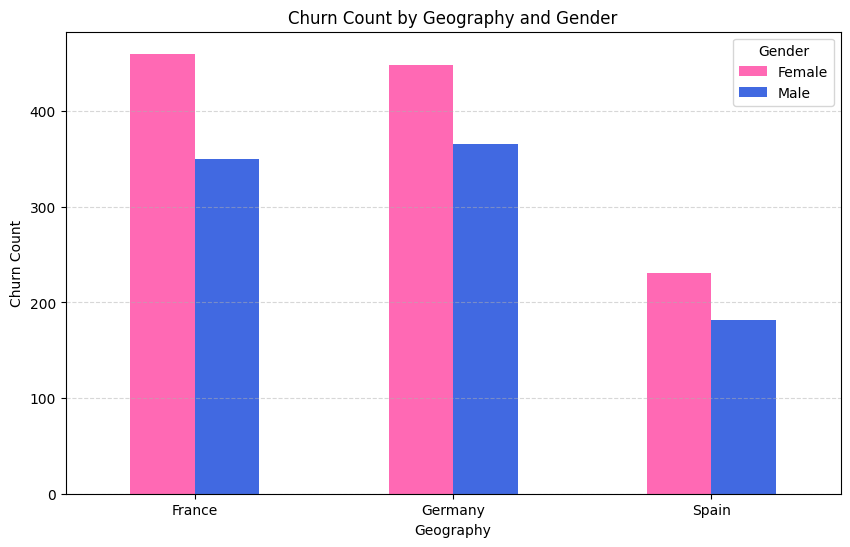

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

print("Churn by Geography & Gender")

# SQL Query 
sql_result_1 = spark.sql("""
    SELECT 
        Geography, 
        Gender, 
        COUNT(*) as Churn_Count, 
        ROUND(AVG(EstimatedSalary), 2) as Avg_Salary, 
        ROUND(AVG(CreditScore), 0) as Avg_Credit_Score
    FROM customers 
    WHERE Exited = 1 
    GROUP BY Geography, Gender 
    ORDER BY Churn_Count DESC
""")

sql_result_1.show()

# Generating Plot 
plot_data = sql_result_1.toPandas()

pivot_table = plot_data.pivot(index='Geography', columns='Gender', values='Churn_Count')

# Plotting
ax = pivot_table.plot(kind='bar', figsize=(10, 6), color=['#FF69B4', '#4169E1'])

plt.title("Churn Count by Geography and Gender")
plt.xlabel("Geography")
plt.ylabel("Churn Count")
plt.xticks(rotation=0)
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

### 3.2. Segmentation by Credit Score (Complex Query with CASE WHEN)

Credit Score Segmentation
+--------------------+--------------+-----------+
|         Score_Group|Customer_Count|Avg_Balance|
+--------------------+--------------+-----------+
|   High Score (>750)|          1598|   78740.13|
|Medium Score (600...|          5368|   76266.67|
|    Low Score (<600)|          3034|   75686.45|
+--------------------+--------------+-----------+



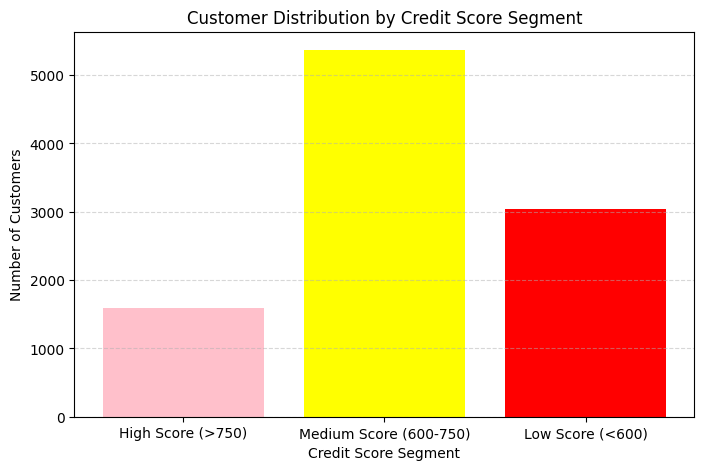

In [5]:
print("Credit Score Segmentation")


sql_result_2 = spark.sql("""
    SELECT 
        CASE 
            WHEN CreditScore < 600 THEN 'Low Score (<600)'
            WHEN CreditScore BETWEEN 600 AND 750 THEN 'Medium Score (600-750)'
            ELSE 'High Score (>750)'
        END AS Score_Group,
        COUNT(*) as Customer_Count,
        ROUND(AVG(Balance), 2) as Avg_Balance
    FROM customers
    GROUP BY 
        CASE 
            WHEN CreditScore < 600 THEN 'Low Score (<600)'
            WHEN CreditScore BETWEEN 600 AND 750 THEN 'Medium Score (600-750)'
            ELSE 'High Score (>750)'
        END
    ORDER BY Avg_Balance DESC
""")

sql_result_2.show()

# Generating Plot
plot_data_2 = sql_result_2.toPandas()

plt.figure(figsize=(8,5))
plt.bar(plot_data_2['Score_Group'], plot_data_2['Customer_Count'], color=['pink', 'yellow', 'red'])

plt.title("Customer Distribution by Credit Score Segment")
plt.xlabel("Credit Score Segment")
plt.ylabel("Number of Customers")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

---
## PART 4: Machine Learning Applications
Two different ML models are implemented: Classification (Churn Prediction) and Regression (Salary Prediction).

### 4.1. Application 1: Classification (Churn Prediction)
Using Logistic Regression to predict whether a customer will exit the bank.

Training Logistic Regression Model

Model Accuracy: %80.52


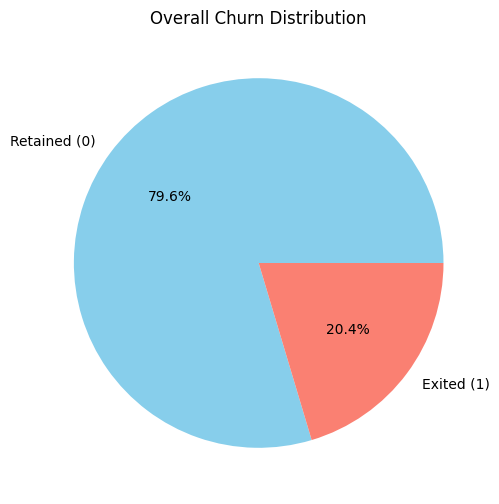

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Feature Selection
feature_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_ml = assembler.transform(df)

# Split Data
train_data, test_data = data_ml.randomSplit([0.7, 0.3])

# Train Model
print("Training Logistic Regression Model")
lr = LogisticRegression(labelCol="Exited", featuresCol="features")
lr_model = lr.fit(train_data)

# Evaluate
predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"\nModel Accuracy: %{accuracy * 100:.2f}")

# Generating Pie Chart
df_pandas = df.select("Exited").toPandas()
plt.figure(figsize=(6,6))
plt.pie(df_pandas["Exited"].value_counts(), 
        labels=['Retained (0)', 'Exited (1)'], 
        autopct='%1.1f%%', 
        colors=['skyblue', 'salmon'])
plt.title("Overall Churn Distribution")
plt.show()

### 4.2. Application 2: Regression (Salary Prediction)
Using Linear Regression to estimate a customer's salary based on Age, Credit Score, and Tenure.

Training Linear Regression Model...


25/12/21 20:03:00 WARN Instrumentation: [2720857b] regParam is zero, which might cause numerical instability and overfitting.



--- Regression Results ---
Root Mean Squared Error (RMSE): 57205.90


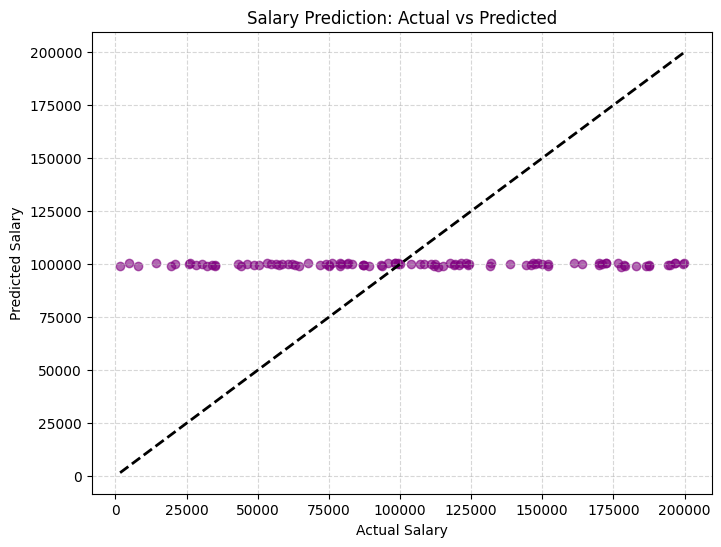

In [28]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# --- ML APPLICATION 2: SALARY PREDICTION (REGRESSION) ---

# Vector Assembler
assembler_reg = VectorAssembler(inputCols=['Age', 'CreditScore', 'Tenure'], outputCol="features_salary")
df_reg = assembler_reg.transform(df)

# Split Data
train_reg, test_reg = df_reg.randomSplit([0.8, 0.2])

# Train Model
print("Training Linear Regression Model...")
lr_reg = LinearRegression(featuresCol="features_salary", labelCol="EstimatedSalary")
lr_reg_model = lr_reg.fit(train_reg)

# Evaluate (RMSE)
pred_reg = lr_reg_model.transform(test_reg)
evaluator_reg = RegressionEvaluator(labelCol="EstimatedSalary", predictionCol="prediction", metricName="rmse")
rmse = evaluator_reg.evaluate(pred_reg)

print("\n--- Regression Results ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Taking a sample for cleaner visualization
plot_data = pred_reg.select("EstimatedSalary", "prediction").limit(100).toPandas()

plt.figure(figsize=(8,6))
plt.scatter(plot_data["EstimatedSalary"], plot_data["prediction"], color='purple', alpha=0.6)

# Ideal prediction line
plt.plot([plot_data["EstimatedSalary"].min(), plot_data["EstimatedSalary"].max()], 
         [plot_data["EstimatedSalary"].min(), plot_data["EstimatedSalary"].max()], 
         'k--', lw=2)

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Salary Prediction: Actual vs Predicted")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

